In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import glob
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

2025-02-04 12:32:50.897970: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
WINDOW_LENGTH = 256  # data window
STRIDE = 128        # stride
BATCH_SIZE = 64  # batch
EPOCHS = 100  # epoch
LEARNING_RATE = 0.0001  # lr
PROJ_DIM = 128  # embedding dimension

In [3]:
datapath = "../../../data/SisFall_Dataset/" 

In [4]:
'''
        Each file contains nine columns and a different number of rows depending on the test length.
        
        1st column is the acceleration data in the X axis measured by the sensor ADXL345.
        2nd column is the acceleration data in the Y axis measured by the sensor ADXL345.
        3rd column is the acceleration data in the Z axis measured by the sensor ADXL345.

        4th column is the rotation data in the X axis measured by the sensor ITG3200.
        5th column is the rotation data in the Y axis measured by the sensor ITG3200.
        6th column is the rotation data in the Z axis measured by the sensor ITG3200.

        7th column is the acceleration data in the X axis measured by the sensor MMA8451Q.
        8th column is the acceleration data in the Y axis measured by the sensor MMA8451Q.
        9th column is the acceleration data in the Z axis measured by the sensor MMA8451Q.
        
        Data are in bits with the following characteristics:

        ADXL345:
        Resolution: 13 bits
        Range: +-16g

        ITG3200
        Resolution: 16 bits
        Range: +-2000°/s

        MMA8451Q:
        Resolution: 14 bits
        Range: +-8g
'''

'\n        Each file contains nine columns and a different number of rows depending on the test length.\n        \n        1st column is the acceleration data in the X axis measured by the sensor ADXL345.\n        2nd column is the acceleration data in the Y axis measured by the sensor ADXL345.\n        3rd column is the acceleration data in the Z axis measured by the sensor ADXL345.\n\n        4th column is the rotation data in the X axis measured by the sensor ITG3200.\n        5th column is the rotation data in the Y axis measured by the sensor ITG3200.\n        6th column is the rotation data in the Z axis measured by the sensor ITG3200.\n\n        7th column is the acceleration data in the X axis measured by the sensor MMA8451Q.\n        8th column is the acceleration data in the Y axis measured by the sensor MMA8451Q.\n        9th column is the acceleration data in the Z axis measured by the sensor MMA8451Q.\n        \n        Data are in bits with the following characteristics:\

In [5]:
adl_activities = [f'D{str(i).zfill(2)}' for i in range(1, 20)]  # D01-D19
fall_activities = [f'F{str(i).zfill(2)}' for i in range(1, 16)]  # F01-F15

label2id = {act: 0 for act in adl_activities}
label2id.update({act: 1 for act in fall_activities})

adult_subjects = [f'SA{str(i).zfill(2)}' for i in range(1, 24)]  # SA01-SA23
elderly_subjects = [f'SE{str(i).zfill(2)}' for i in range(1, 16)]  # SE01-SE15

train_sa = adult_subjects[:16]    # 16 subjects
val_sa = adult_subjects[16:19]    # 3 subjects
test_sa = adult_subjects[19:]     # 4 subjects

train_se = elderly_subjects[:10]  # 10 subjects
val_se = elderly_subjects[10:12]  # 2 subjects
test_se = elderly_subjects[12:]   # 3 subjects

train_split = train_sa + train_se
val_split = val_sa + val_se
test_split = test_sa + test_se

all_subjects = adult_subjects + elderly_subjects  # all subjects

In [6]:
def read_sensor_file(filepath) :
   """
       first 6 columns : ADXL345 acc + ITG3200 gyro
   """
   with open(filepath, 'r') as file:
       content = file.read()

   content = content.replace(' ', '')  # delete blank
   rows = []

   for line in content.split(';\n'): 
       if line.strip():
           try:
               values = [float(x) for x in line.split(',')[:6]]
               rows.append(values)
           except (ValueError, IndexError):
               continue

   return np.array(rows)

In [7]:
def split_sequences(data, labels, 
                    window_length=WINDOW_LENGTH, 
                    stride=STRIDE,
                    clean=True):
    idx = 0
    endidx = len(data)
    windows = []
    window_labels = []
    
    while idx < endidx - window_length:
        data_segment = data[idx:idx+window_length].T
        
        if clean and len(np.unique(labels[idx:idx + window_length])) > 1:
            pass
        else:
            windows.append(data_segment)
            window_labels.append(labels[idx+window_length])
        
        idx += stride
    
    if len(windows) == 0:
        return None, None
    
    return np.stack(windows), np.asarray(window_labels)

In [8]:
'''
   TRAIN DATA PREPARING PART
   ONLY "ADL"
'''
train_data_normal = []  
train_labels_normal = [] 

# for subject in tqdm(train_split):  
for subject in tqdm(all_subjects, desc="Processing training data (ADL)"):
   subject_dir = os.path.join(datapath, subject)
   
   if subject.startswith('SE') and subject != 'SE06':
       continue
       
   for activity in adl_activities:
       activity_pattern = os.path.join(subject_dir, f"{activity}*.txt")
       activity_files = glob.glob(activity_pattern)
       
       for file_path in activity_files:
           try:
               raw_data = read_sensor_file(file_path)
               if raw_data is not None and raw_data.shape[1] == 6:
                   sensor_data = raw_data
                   activity_labels = np.full(len(sensor_data), label2id[activity])
                   
                   windows_data, windows_labels = split_sequences(
                       sensor_data, activity_labels, 
                       WINDOW_LENGTH, STRIDE
                   )
                   
                   if windows_data is not None and len(windows_data) > 0:
                       train_data_normal.append(windows_data)
                       train_labels_normal.append(windows_labels)
                   
           except Exception as e: 
               print(f"Error processing file {file_path}: {e}")
               
train_data_normal = np.concatenate(train_data_normal, axis=0)
train_labels_normal = np.concatenate(train_labels_normal)

print (f"# of windows: {len(train_data_normal)}")
print (f"data shape: {train_data_normal.shape}")
print (f"labels shape: {train_labels_normal.shape}")
unique_labels, counts = np.unique(train_labels_normal, return_counts=True)
print (dict(zip(unique_labels, counts)))

Processing training data (ADL): 100%|███████████| 38/38 [00:18<00:00,  2.07it/s]


# of windows: 52925
data shape: (52925, 6, 256)
labels shape: (52925,)
{0: 52925}


In [9]:
'''
   TEST DATA PREPARING PART
   ADL + FALL
'''
test_data = []
test_labels = []

# for subject in tqdm(test_split):
for subject in tqdm(all_subjects, desc="Processing test data (ADL + FALL)"):
   subject_dir = os.path.join(datapath, subject)
   
   is_elderly = subject.startswith('SE')
   
   if not (is_elderly and subject != 'SE06'): 
       for activity in adl_activities:
           activity_pattern = os.path.join(subject_dir, f"{activity}*.txt")
           activity_files = glob.glob(activity_pattern)
           
           for file_path in activity_files:
               try:
                   raw_data = read_sensor_file(file_path)
                   if raw_data is not None and raw_data.shape[1] == 6:
                       sensor_data = raw_data
                       activity_labels = np.full(len(sensor_data), label2id[activity])
                       
                       windows_data, windows_labels = split_sequences(
                           sensor_data, activity_labels,
                           WINDOW_LENGTH, STRIDE
                       )
                       
                       if windows_data is not None and len(windows_data) > 0:
                           test_data.append(windows_data)
                           test_labels.append(windows_labels)
                           
               except Exception as e:
                   print(f"Error processing file {file_path}: {e}")
   
   if not is_elderly or subject == 'SE06':
       for activity in fall_activities:
           activity_pattern = os.path.join(subject_dir, f"{activity}*.txt")
           activity_files = glob.glob(activity_pattern)
           
           for file_path in activity_files:
               try:
                   raw_data = read_sensor_file(file_path)
                   if raw_data is not None and raw_data.shape[1] == 6:
                       sensor_data = raw_data
                       activity_labels = np.full(len(sensor_data), label2id[activity])
                       
                       windows_data, windows_labels = split_sequences(
                           sensor_data, activity_labels,
                           WINDOW_LENGTH, STRIDE
                       )
                       
                       if windows_data is not None and len(windows_data) > 0:
                           test_data.append(windows_data)
                           test_labels.append(windows_labels)
                           
               except Exception as e:
                   print(f"Error processing file {file_path}: {e}")

test_data = np.concatenate(test_data, axis=0)
test_labels = np.concatenate(test_labels)

print (f"# of windows: {len(test_data)}")
print (f"data shape: {test_data.shape}")
print (f"labels shape: {test_labels.shape}")
unique_labels, counts = np.unique(test_labels, return_counts=True)
print(dict(zip(unique_labels, counts)))

Processing test data (ADL + FALL): 100%|████████| 38/38 [00:32<00:00,  1.17it/s]


# of windows: 92480
data shape: (92480, 6, 256)
labels shape: (92480,)
{0: 52925, 1: 39555}


In [10]:
train_data_shape = train_data_normal.shape
test_data_shape = test_data.shape

train_data_2d = train_data_normal.reshape(-1, train_data_normal.shape[-1])
test_data_2d = test_data.reshape(-1, test_data.shape[-1])

scaler = StandardScaler()
train_data_2d = scaler.fit_transform(train_data_2d)
test_data_2d = scaler.transform(test_data_2d)

train_data_normal = train_data_2d.reshape(train_data_shape)
test_data = test_data_2d.reshape(test_data_shape)

In [11]:
train_acc_normal = train_data_normal[..., :3] 
train_gyro_normal = train_data_normal[..., 3:6]  
# (x, y, z)

test_acc = test_data[..., :3]  
test_gyro = test_data[..., 3:6] 

train_dataset = tf.data.Dataset.from_tensor_slices((train_acc_normal, train_gyro_normal))
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(
    ((test_acc, test_gyro), test_labels)
).batch(BATCH_SIZE)

print (f"train data - accel shape: {train_acc_normal.shape}")
print (f"train data - gyro shape: {train_gyro_normal.shape}")
print (f"test data - accel shape: {test_acc.shape}")
print (f"test data - gyro shape: {test_gyro.shape}")
print (f"# of training batches: {len(train_dataset)}")
print (f"# of test batches: {len(test_dataset)}")

train data - accel shape: (52925, 6, 3)
train data - gyro shape: (52925, 6, 3)
test data - accel shape: (92480, 6, 3)
test data - gyro shape: (92480, 6, 3)
# of training batches: 827
# of test batches: 1445


------

In [12]:
class Encoder(Model):
    def __init__(self, in_feat, out_feat, num_encoders=1, use_skip=True):
        super(Encoder, self).__init__()
        self.use_skip = use_skip
        self.num_encoders = num_encoders
        
        for i in range(num_encoders):
            setattr(self, f'conv1_{i}', layers.Conv1D(filters=out_feat*3, 
                                                      kernel_size=7, padding='same', 
                                                      activation='relu'))
            setattr(self, f'maxpool1_{i}', layers.MaxPooling1D(pool_size=2, padding='same'))
            setattr(self, f'conv2_{i}', layers.Conv1D(filters=out_feat*2, 
                                                      kernel_size=5, padding='same', 
                                                      activation='relu'))
            setattr(self, f'maxpool2_{i}', layers.MaxPooling1D(pool_size=2, padding='same'))
            setattr(self, f'conv3_{i}', layers.Conv1D(filters=out_feat*1, 
                                                      kernel_size=3, padding='same', 
                                                      activation='relu'))
    
    def call(self, x, training=False):
        for i in range(self.num_encoders):
            if self.use_skip and i > 0:
                identity = x
            
            x = getattr(self, f'conv1_{i}')(x)
            x = getattr(self, f'maxpool1_{i}')(x)
            x = getattr(self, f'conv2_{i}')(x)
            x = getattr(self, f'maxpool2_{i}')(x)
            x = getattr(self, f'conv3_{i}')(x)
            
            if self.use_skip and i > 0:
                x = x + identity
        
        return tf.reduce_mean(x, axis=1)

In [13]:
class Decoder(Model):
    def __init__(self, in_feat, out_feat):
        super(Decoder, self).__init__()
        
        self.reshape = layers.Reshape((1, in_feat))
        
        self.conv1 = layers.Conv1DTranspose(
            filters=out_feat*3,
            kernel_size=3,
            padding='same',
            activation='relu'
        )
        self.upsample1 = layers.UpSampling1D(size=3)  # 1 -> 3
        
        self.conv2 = layers.Conv1DTranspose(
            filters=out_feat*2,
            kernel_size=5,
            padding='same',
            activation='relu'
        )
        self.upsample2 = layers.UpSampling1D(size=2)  # 3 -> 6
        
        self.conv3 = layers.Conv1DTranspose(
            filters=3,  # x,y,z
            kernel_size=7,
            padding='same'
        )
    
    def call(self, x, training=False):
        x = self.reshape(x)  # (batch, 1, features)
        x = self.conv1(x)
        x = self.upsample1(x)  # (batch, 3, features)
        x = self.conv2(x)
        x = self.upsample2(x)  # (batch, 6, features)
        x = self.conv3(x)
        return x

In [14]:
class CAGE(Model):
   def __init__(self, n_feat=3, proj_dim=128):
       super(CAGE, self).__init__()
       self.proj_dim = proj_dim
       
       self.enc_A = Encoder(n_feat, 64)
       self.enc_G = Encoder(n_feat, 64)
       
       self.dec_A = Decoder(64, n_feat)
       self.dec_G = Decoder(64, n_feat)
       
       if self.proj_dim > 0:
           self.proj_A = layers.Dense(proj_dim, use_bias=False)
           self.proj_G = layers.Dense(proj_dim, use_bias=False)
       
       self.temperature = tf.constant(0.1)
   
   def call(self, x_accel, x_gyro, return_feat=False, training=False):
       f_accel = self.enc_A(x_accel, training=training)
       f_gyro = self.enc_G(x_gyro, training=training)
       
       x_accel_recon = self.dec_A(f_accel)
       x_gyro_recon = self.dec_G(f_gyro)
       
       if self.proj_dim > 0:
           e_accel = self.proj_A(f_accel)
           e_gyro = self.proj_G(f_gyro)
       else:
           e_accel = f_accel
           e_gyro = f_gyro
       
       e_accel = tf.math.l2_normalize(e_accel, axis=1)
       e_gyro = tf.math.l2_normalize(e_gyro, axis=1)
       
       sim_matrix = tf.matmul(e_accel, e_gyro, transpose_b=True) / self.temperature
       
       if return_feat:
           return sim_matrix, (x_accel_recon, x_gyro_recon), (e_accel, e_gyro)
       
       return sim_matrix, (x_accel_recon, x_gyro_recon)

In [15]:
model = CAGE(proj_dim=PROJ_DIM)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE
)

In [16]:
# @tf.function
# def contrastive_loss(logits):
#     """NT-Xent Loss"""
#     batch_size = tf.shape(logits)[0]
    
#     labels = tf.eye(batch_size) # diagonal matrix 
    
#     '''
#         loss calculating using CrossEntropy
#     '''
#     loss = tf.keras.losses.categorical_crossentropy(
#         labels, 
#         tf.nn.softmax(logits, axis=-1), 
#         from_logits=False
#     )
    
#     return tf.reduce_mean(loss)

def contrastive_loss(sim_matrix):
    epsilon = 1e-8
    sim_matrix = sim_matrix + epsilon
    
    batch_size = tf.shape(sim_matrix)[0]
    
    labels = tf.eye(batch_size)
    
    loss_1 = tf.keras.losses.categorical_crossentropy(
        labels,
        tf.nn.softmax(sim_matrix, axis=1),
        from_logits=False
    )
    
    loss_2 = tf.keras.losses.categorical_crossentropy(
        labels,
        tf.nn.softmax(sim_matrix, axis=0),
        from_logits=False
    )
    
    total_loss = (loss_1 + loss_2) / 2
    return tf.reduce_mean(total_loss)

In [17]:
def reconstruction_loss(x_original, x_recon):
    x_original = tf.cast(x_original, tf.float32)
    x_recon = tf.cast(x_recon, tf.float32)
    return tf.reduce_mean(tf.square(x_original - x_recon))

def combined_loss(sim_matrix, x_accel, x_gyro, x_accel_recon, x_gyro_recon):
    sim_loss = contrastive_loss(sim_matrix)
    
    x_accel = tf.cast(x_accel, tf.float32)
    x_gyro = tf.cast(x_gyro, tf.float32)
    x_accel_recon = tf.cast(x_accel_recon, tf.float32)
    x_gyro_recon = tf.cast(x_gyro_recon, tf.float32)
    
    recon_loss_accel = reconstruction_loss(x_accel, x_accel_recon)
    recon_loss_gyro = reconstruction_loss(x_gyro, x_gyro_recon)
    total_recon_loss = (recon_loss_accel + recon_loss_gyro) / 2
    
    alpha = 0.5  
    beta = 0.5   
    
    return alpha * sim_loss + beta * total_recon_loss

In [18]:
@tf.function
def train_step(model, optimizer, x_accel, x_gyro):
    with tf.GradientTape() as tape:
        sim_matrix, (x_accel_recon, x_gyro_recon), _ = model(x_accel, 
                                                             x_gyro, 
                                                             return_feat=True, 
                                                             training=True)
        loss = combined_loss(sim_matrix, x_accel, x_gyro, x_accel_recon, x_gyro_recon)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    gradients = [tf.clip_by_norm(g, 0.5) if g is not None else g for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

----

In [19]:
print (train_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 6, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 6, 3), dtype=tf.float64, name=None))>


In [20]:
train_losses = []
best_loss = float('inf')

for epoch in range(EPOCHS):
    epoch_losses = []
    
    for acc_batch, gyro_batch in tqdm(train_dataset, desc=f'Epoch {epoch + 1}/{EPOCHS}'):
        loss = train_step(model, optimizer, acc_batch, gyro_batch)  
        epoch_losses.append(loss.numpy())
    
    avg_loss = np.mean(epoch_losses)
    train_losses.append(avg_loss)
    
    print (f"mean value of loss : {avg_loss:.4f}")
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        print (f"best loss achieved : {best_loss:.4f}")

        
print("END THE LEARNING")
print(f"final best loss: {best_loss:.4f}")

Epoch 1/100: 100%|████████████████████████████| 827/827 [00:14<00:00, 55.94it/s]


mean value of loss : 1.3635
best loss achieved : 1.3635


Epoch 2/100: 100%|████████████████████████████| 827/827 [00:12<00:00, 65.64it/s]


mean value of loss : 0.9991
best loss achieved : 0.9991


Epoch 3/100: 100%|████████████████████████████| 827/827 [00:12<00:00, 64.07it/s]


mean value of loss : 0.8369
best loss achieved : 0.8369


Epoch 4/100: 100%|████████████████████████████| 827/827 [00:12<00:00, 65.59it/s]


mean value of loss : 0.7279
best loss achieved : 0.7279


Epoch 5/100: 100%|████████████████████████████| 827/827 [00:12<00:00, 68.31it/s]


mean value of loss : 0.6439
best loss achieved : 0.6439


Epoch 6/100: 100%|████████████████████████████| 827/827 [00:14<00:00, 58.81it/s]


mean value of loss : 0.5881
best loss achieved : 0.5881


Epoch 7/100: 100%|████████████████████████████| 827/827 [00:34<00:00, 24.24it/s]


mean value of loss : 0.5332
best loss achieved : 0.5332


Epoch 8/100: 100%|████████████████████████████| 827/827 [00:41<00:00, 20.16it/s]


mean value of loss : 0.4915
best loss achieved : 0.4915


Epoch 9/100: 100%|████████████████████████████| 827/827 [00:14<00:00, 57.68it/s]


mean value of loss : 0.4464
best loss achieved : 0.4464


Epoch 10/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 72.02it/s]


mean value of loss : 0.4028
best loss achieved : 0.4028


Epoch 11/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 74.06it/s]


mean value of loss : 0.3725
best loss achieved : 0.3725


Epoch 12/100: 100%|███████████████████████████| 827/827 [00:10<00:00, 78.11it/s]


mean value of loss : 0.3514
best loss achieved : 0.3514


Epoch 13/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 71.69it/s]


mean value of loss : 0.3348
best loss achieved : 0.3348


Epoch 14/100: 100%|███████████████████████████| 827/827 [00:13<00:00, 62.05it/s]


mean value of loss : 0.3251
best loss achieved : 0.3251


Epoch 15/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 71.31it/s]


mean value of loss : 0.3155
best loss achieved : 0.3155


Epoch 16/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 69.62it/s]


mean value of loss : 0.3052
best loss achieved : 0.3052


Epoch 17/100: 100%|███████████████████████████| 827/827 [00:12<00:00, 63.79it/s]


mean value of loss : 0.2953
best loss achieved : 0.2953


Epoch 18/100: 100%|███████████████████████████| 827/827 [00:13<00:00, 62.38it/s]


mean value of loss : 0.2909
best loss achieved : 0.2909


Epoch 19/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 69.32it/s]


mean value of loss : 0.2818
best loss achieved : 0.2818


Epoch 20/100: 100%|███████████████████████████| 827/827 [00:12<00:00, 66.76it/s]


mean value of loss : 0.2755
best loss achieved : 0.2755


Epoch 21/100: 100%|███████████████████████████| 827/827 [00:14<00:00, 57.05it/s]


mean value of loss : 0.2709
best loss achieved : 0.2709


Epoch 22/100: 100%|███████████████████████████| 827/827 [00:15<00:00, 54.16it/s]


mean value of loss : 0.2660
best loss achieved : 0.2660


Epoch 23/100: 100%|███████████████████████████| 827/827 [00:14<00:00, 55.31it/s]


mean value of loss : 0.2589
best loss achieved : 0.2589


Epoch 24/100: 100%|███████████████████████████| 827/827 [00:13<00:00, 60.69it/s]


mean value of loss : 0.2567
best loss achieved : 0.2567


Epoch 25/100: 100%|███████████████████████████| 827/827 [00:14<00:00, 56.21it/s]


mean value of loss : 0.2499
best loss achieved : 0.2499


Epoch 26/100: 100%|███████████████████████████| 827/827 [00:13<00:00, 60.26it/s]


mean value of loss : 0.2461
best loss achieved : 0.2461


Epoch 27/100: 100%|███████████████████████████| 827/827 [00:14<00:00, 58.45it/s]


mean value of loss : 0.2461
best loss achieved : 0.2461


Epoch 28/100: 100%|███████████████████████████| 827/827 [00:12<00:00, 67.75it/s]


mean value of loss : 0.2424
best loss achieved : 0.2424


Epoch 29/100: 100%|███████████████████████████| 827/827 [00:12<00:00, 65.72it/s]


mean value of loss : 0.2371
best loss achieved : 0.2371


Epoch 30/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 69.92it/s]


mean value of loss : 0.2354
best loss achieved : 0.2354


Epoch 31/100: 100%|███████████████████████████| 827/827 [00:12<00:00, 66.12it/s]


mean value of loss : 0.2323
best loss achieved : 0.2323


Epoch 32/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 68.97it/s]


mean value of loss : 0.2304
best loss achieved : 0.2304


Epoch 33/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 74.16it/s]


mean value of loss : 0.2269
best loss achieved : 0.2269


Epoch 34/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 74.04it/s]


mean value of loss : 0.2218
best loss achieved : 0.2218


Epoch 35/100: 100%|███████████████████████████| 827/827 [00:12<00:00, 68.64it/s]


mean value of loss : 0.2199
best loss achieved : 0.2199


Epoch 36/100: 100%|███████████████████████████| 827/827 [00:10<00:00, 75.69it/s]


mean value of loss : 0.2179
best loss achieved : 0.2179


Epoch 37/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 73.77it/s]


mean value of loss : 0.2137
best loss achieved : 0.2137


Epoch 38/100: 100%|███████████████████████████| 827/827 [00:12<00:00, 66.80it/s]


mean value of loss : 0.2134
best loss achieved : 0.2134


Epoch 39/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 73.37it/s]


mean value of loss : 0.2097
best loss achieved : 0.2097


Epoch 40/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 73.67it/s]


mean value of loss : 0.2102


Epoch 41/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 75.14it/s]


mean value of loss : 0.2047
best loss achieved : 0.2047


Epoch 42/100: 100%|███████████████████████████| 827/827 [00:12<00:00, 68.22it/s]


mean value of loss : 0.2049


Epoch 43/100: 100%|███████████████████████████| 827/827 [00:12<00:00, 65.68it/s]


mean value of loss : 0.2040
best loss achieved : 0.2040


Epoch 44/100: 100%|███████████████████████████| 827/827 [00:13<00:00, 61.42it/s]


mean value of loss : 0.2029
best loss achieved : 0.2029


Epoch 45/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 70.29it/s]


mean value of loss : 0.1986
best loss achieved : 0.1986


Epoch 46/100: 100%|███████████████████████████| 827/827 [00:12<00:00, 65.79it/s]


mean value of loss : 0.1979
best loss achieved : 0.1979


Epoch 47/100: 100%|███████████████████████████| 827/827 [00:12<00:00, 66.91it/s]


mean value of loss : 0.1963
best loss achieved : 0.1963


Epoch 48/100: 100%|███████████████████████████| 827/827 [00:12<00:00, 65.47it/s]


mean value of loss : 0.1925
best loss achieved : 0.1925


Epoch 49/100: 100%|███████████████████████████| 827/827 [00:13<00:00, 60.03it/s]


mean value of loss : 0.1930


Epoch 50/100: 100%|███████████████████████████| 827/827 [00:12<00:00, 66.05it/s]


mean value of loss : 0.1926


Epoch 51/100: 100%|███████████████████████████| 827/827 [00:12<00:00, 64.50it/s]


mean value of loss : 0.1904
best loss achieved : 0.1904


Epoch 52/100: 100%|███████████████████████████| 827/827 [00:13<00:00, 59.80it/s]


mean value of loss : 0.1858
best loss achieved : 0.1858


Epoch 53/100: 100%|███████████████████████████| 827/827 [00:14<00:00, 58.10it/s]


mean value of loss : 0.1843
best loss achieved : 0.1843


Epoch 54/100: 100%|███████████████████████████| 827/827 [00:14<00:00, 56.25it/s]


mean value of loss : 0.1826
best loss achieved : 0.1826


Epoch 55/100: 100%|███████████████████████████| 827/827 [00:19<00:00, 42.52it/s]


mean value of loss : 0.1834


Epoch 56/100: 100%|███████████████████████████| 827/827 [00:13<00:00, 59.75it/s]


mean value of loss : 0.1793
best loss achieved : 0.1793


Epoch 57/100: 100%|███████████████████████████| 827/827 [00:13<00:00, 61.66it/s]


mean value of loss : 0.1787
best loss achieved : 0.1787


Epoch 58/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 69.90it/s]


mean value of loss : 0.1799


Epoch 59/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 69.65it/s]


mean value of loss : 0.1754
best loss achieved : 0.1754


Epoch 60/100: 100%|███████████████████████████| 827/827 [00:13<00:00, 62.18it/s]


mean value of loss : 0.1749
best loss achieved : 0.1749


Epoch 61/100: 100%|███████████████████████████| 827/827 [00:13<00:00, 60.00it/s]


mean value of loss : 0.1731
best loss achieved : 0.1731


Epoch 62/100: 100%|███████████████████████████| 827/827 [00:13<00:00, 61.59it/s]


mean value of loss : 0.1726
best loss achieved : 0.1726


Epoch 63/100: 100%|███████████████████████████| 827/827 [00:13<00:00, 62.25it/s]


mean value of loss : 0.1715
best loss achieved : 0.1715


Epoch 64/100: 100%|███████████████████████████| 827/827 [00:13<00:00, 62.23it/s]


mean value of loss : 0.1707
best loss achieved : 0.1707


Epoch 65/100: 100%|███████████████████████████| 827/827 [00:12<00:00, 64.83it/s]


mean value of loss : 0.1707
best loss achieved : 0.1707


Epoch 66/100: 100%|███████████████████████████| 827/827 [00:12<00:00, 66.03it/s]


mean value of loss : 0.1688
best loss achieved : 0.1688


Epoch 67/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 71.21it/s]


mean value of loss : 0.1668
best loss achieved : 0.1668


Epoch 68/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 71.17it/s]


mean value of loss : 0.1666
best loss achieved : 0.1666


Epoch 69/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 70.52it/s]


mean value of loss : 0.1638
best loss achieved : 0.1638


Epoch 70/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 74.69it/s]


mean value of loss : 0.1660


Epoch 71/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 73.10it/s]


mean value of loss : 0.1635
best loss achieved : 0.1635


Epoch 72/100: 100%|███████████████████████████| 827/827 [00:10<00:00, 77.52it/s]


mean value of loss : 0.1619
best loss achieved : 0.1619


Epoch 73/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 74.83it/s]


mean value of loss : 0.1607
best loss achieved : 0.1607


Epoch 74/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 71.77it/s]


mean value of loss : 0.1587
best loss achieved : 0.1587


Epoch 75/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 72.75it/s]


mean value of loss : 0.1596


Epoch 76/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 74.51it/s]


mean value of loss : 0.1568
best loss achieved : 0.1568


Epoch 77/100: 100%|███████████████████████████| 827/827 [00:10<00:00, 78.13it/s]


mean value of loss : 0.1560
best loss achieved : 0.1560


Epoch 78/100: 100%|███████████████████████████| 827/827 [00:10<00:00, 77.32it/s]


mean value of loss : 0.1551
best loss achieved : 0.1551


Epoch 79/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 70.14it/s]


mean value of loss : 0.1528
best loss achieved : 0.1528


Epoch 80/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 73.03it/s]


mean value of loss : 0.1542


Epoch 81/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 73.74it/s]


mean value of loss : 0.1538


Epoch 82/100: 100%|███████████████████████████| 827/827 [00:12<00:00, 64.95it/s]


mean value of loss : 0.1501
best loss achieved : 0.1501


Epoch 83/100: 100%|███████████████████████████| 827/827 [00:14<00:00, 58.79it/s]


mean value of loss : 0.1500
best loss achieved : 0.1500


Epoch 84/100: 100%|███████████████████████████| 827/827 [00:12<00:00, 64.13it/s]


mean value of loss : 0.1519


Epoch 85/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 70.63it/s]


mean value of loss : 0.1497
best loss achieved : 0.1497


Epoch 86/100: 100%|███████████████████████████| 827/827 [00:12<00:00, 67.87it/s]


mean value of loss : 0.1485
best loss achieved : 0.1485


Epoch 87/100: 100%|███████████████████████████| 827/827 [00:13<00:00, 62.05it/s]


mean value of loss : 0.1477
best loss achieved : 0.1477


Epoch 88/100: 100%|███████████████████████████| 827/827 [00:12<00:00, 65.60it/s]


mean value of loss : 0.1464
best loss achieved : 0.1464


Epoch 89/100: 100%|███████████████████████████| 827/827 [00:12<00:00, 64.31it/s]


mean value of loss : 0.1447
best loss achieved : 0.1447


Epoch 90/100: 100%|███████████████████████████| 827/827 [00:12<00:00, 66.41it/s]


mean value of loss : 0.1446
best loss achieved : 0.1446


Epoch 91/100: 100%|███████████████████████████| 827/827 [00:12<00:00, 67.60it/s]


mean value of loss : 0.1440
best loss achieved : 0.1440


Epoch 92/100: 100%|███████████████████████████| 827/827 [00:12<00:00, 65.64it/s]


mean value of loss : 0.1428
best loss achieved : 0.1428


Epoch 93/100: 100%|███████████████████████████| 827/827 [00:12<00:00, 67.42it/s]


mean value of loss : 0.1418
best loss achieved : 0.1418


Epoch 94/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 70.86it/s]


mean value of loss : 0.1422


Epoch 95/100: 100%|███████████████████████████| 827/827 [00:12<00:00, 65.81it/s]


mean value of loss : 0.1445


Epoch 96/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 69.82it/s]


mean value of loss : 0.1430


Epoch 97/100: 100%|███████████████████████████| 827/827 [00:12<00:00, 68.13it/s]


mean value of loss : 0.1408
best loss achieved : 0.1408


Epoch 98/100: 100%|███████████████████████████| 827/827 [00:12<00:00, 64.60it/s]


mean value of loss : 0.1396
best loss achieved : 0.1396


Epoch 99/100: 100%|███████████████████████████| 827/827 [00:11<00:00, 71.73it/s]


mean value of loss : 0.1398


Epoch 100/100: 100%|██████████████████████████| 827/827 [00:11<00:00, 70.42it/s]

mean value of loss : 0.1404
END THE LEARNING
final best loss: 0.1396


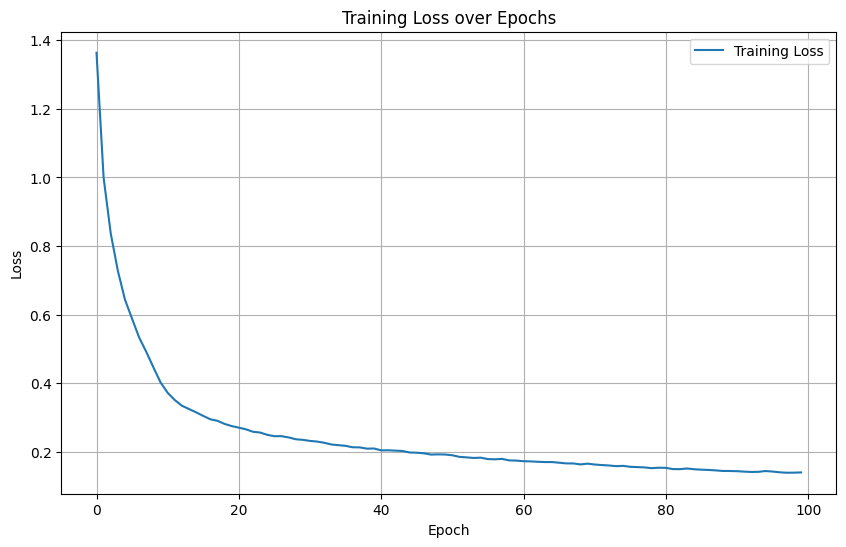

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

----

In [22]:
def compute_anomaly_scores(model, data_loader):
    similarities = []
    recon_errors = []
    labels = []
    
    for (acc_batch, gyro_batch), batch_labels in data_loader:
        acc_batch = tf.cast(acc_batch, tf.float32)
        gyro_batch = tf.cast(gyro_batch, tf.float32)
        
        sim_matrix, (acc_recon, gyro_recon), (e_accel, e_gyro) = model(
            acc_batch, gyro_batch, return_feat=True, training=False
        )
        
        acc_recon = tf.cast(acc_recon, tf.float32)
        gyro_recon = tf.cast(gyro_recon, tf.float32)
        
        # similarities
        batch_similarities = tf.reduce_sum(tf.multiply(e_accel, e_gyro), axis=1)
        
        # reconstruction
        recon_error_acc = tf.reduce_mean(tf.square(acc_batch - acc_recon), axis=[1,2])
        recon_error_gyro = tf.reduce_mean(tf.square(gyro_batch - gyro_recon), axis=[1,2])
        batch_recon_errors = (recon_error_acc + recon_error_gyro) / 2
        
        similarities.extend(batch_similarities.numpy())
        recon_errors.extend(batch_recon_errors.numpy())
        labels.extend(batch_labels.numpy())
    
    return np.array(similarities), np.array(recon_errors), np.array(labels)

In [25]:
normal_similarities = []
normal_recon_errors = []
for acc_batch, gyro_batch in tqdm(train_dataset):
    sim_matrix, (acc_recon, gyro_recon), (e_accel, e_gyro) = model(
        acc_batch, gyro_batch, return_feat=True, training=False
    )
    
    sim = tf.reduce_sum(tf.multiply(e_accel, e_gyro), axis=1)
    
    acc_batch = tf.cast(acc_batch, tf.float32)
    acc_recon = tf.cast(acc_recon, tf.float32)
    gyro_batch = tf.cast(gyro_batch, tf.float32)
    gyro_recon = tf.cast(gyro_recon, tf.float32)
    
    recon_acc = tf.reduce_mean(tf.square(acc_batch - acc_recon), axis=[1,2])
    recon_gyro = tf.reduce_mean(tf.square(gyro_batch - gyro_recon), axis=[1,2])
    recon_error = (recon_acc + recon_gyro) / 2
    
    normal_similarities.extend(sim.numpy())
    normal_recon_errors.extend(recon_error.numpy())

test_similarities, test_recon_errors, test_labels = compute_anomaly_scores(model, test_dataset)

In [26]:
def calculate_similarities(model, test_dataset):
    normal_similarities = []
    fall_similarities = []
    
    for (acc_batch, gyro_batch), labels in test_dataset:
        _, _, (e_accel, e_gyro) = model(acc_batch, gyro_batch, return_feat=True, training=False)
        
        sim = tf.reduce_sum(tf.multiply(e_accel, e_gyro), axis=1)
        sim_numpy = sim.numpy()
        labels_numpy = labels.numpy()
        
        normal_mask = (labels_numpy == 0)
        fall_mask = (labels_numpy == 1)
        
        normal_similarities.extend(sim_numpy[normal_mask])
        fall_similarities.extend(sim_numpy[fall_mask])
    
    return np.array(normal_similarities), np.array(fall_similarities)

normal_sims, fall_sims = calculate_similarities(model, test_dataset)

print("[ ADL data ]")
print(f"  Mean: {np.mean(normal_sims):.4f}")
print(f"  Std: {np.std(normal_sims):.4f}")
print(f"  Min: {np.min(normal_sims):.4f}")
print(f"  Max: {np.max(normal_sims):.4f}")
for i in range (20) :
    print ('ADL ind', i+1, ':', normal_sims[i])

print ()
print("[ FALL data ]")
print(f"  Mean: {np.mean(fall_sims):.4f}")
print(f"  Std: {np.std(fall_sims):.4f}")
print(f"  Min: {np.min(fall_sims):.4f}")
print(f"  Max: {np.max(fall_sims):.4f}")
for i in range (20) :
    print ('FALL ind', i+1, ':', fall_sims[i])

[ ADL data ]
  Mean: 0.9178
  Std: 0.0658
  Min: -0.1395
  Max: 0.9887
ADL ind 1 : 0.87327594
ADL ind 2 : 0.9463725
ADL ind 3 : 0.948074
ADL ind 4 : 0.9511323
ADL ind 5 : 0.96918464
ADL ind 6 : 0.95477897
ADL ind 7 : 0.9512745
ADL ind 8 : 0.91442025
ADL ind 9 : 0.9647955
ADL ind 10 : 0.9715897
ADL ind 11 : 0.94419444
ADL ind 12 : 0.96995556
ADL ind 13 : 0.92409444
ADL ind 14 : 0.9453811
ADL ind 15 : 0.96694964
ADL ind 16 : 0.9631189
ADL ind 17 : 0.9617288
ADL ind 18 : 0.91180766
ADL ind 19 : 0.94234765
ADL ind 20 : 0.90052235

[ FALL data ]
  Mean: 0.8766
  Std: 0.0972
  Min: -0.4740
  Max: 0.9898
FALL ind 1 : 0.85291827
FALL ind 2 : 0.9561565
FALL ind 3 : 0.88790095
FALL ind 4 : 0.9762526
FALL ind 5 : 0.9039582
FALL ind 6 : 0.9573002
FALL ind 7 : 0.9670977
FALL ind 8 : 0.95544386
FALL ind 9 : 0.9463334
FALL ind 10 : 0.9657792
FALL ind 11 : 0.9649739
FALL ind 12 : 0.9575284
FALL ind 13 : 0.96827364
FALL ind 14 : 0.95728874
FALL ind 15 : 0.9382112
FALL ind 16 : 0.72786725
FALL ind 17 : 

In [27]:
sim_threshold = np.percentile(normal_similarities, 10)
recon_threshold = np.percentile(normal_recon_errors, 90)

anomaly_scores = (1 - test_similarities) * 0.5 + test_recon_errors * 0.5
threshold = np.percentile(anomaly_scores, 90)

'''
    low similarities + high reconstruction error == FALL
'''

'\n    low similarities + high reconstruction error == FALL\n'

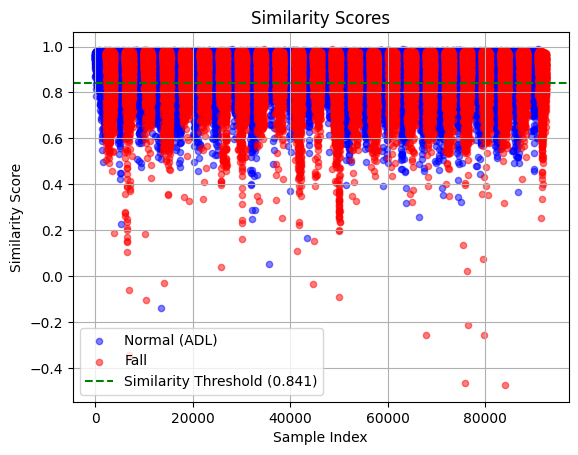

In [29]:
indices = range(len(test_similarities))
plt.scatter([i for i, l in zip(indices, test_labels) if l == 0], 
           [s for s, l in zip(test_similarities, test_labels) if l == 0],
           c='blue', label='Normal (ADL)', alpha=0.5, s=20)
plt.scatter([i for i, l in zip(indices, test_labels) if l == 1],
           [s for s, l in zip(test_similarities, test_labels) if l == 1],
           c='red', label='Fall', alpha=0.5, s=20)
plt.axhline(y=sim_threshold, color='green', linestyle='--', 
           label=f'Similarity Threshold ({sim_threshold:.3f})')
plt.xlabel('Sample Index')
plt.ylabel('Similarity Score')
plt.title('Similarity Scores')
plt.legend()
plt.grid(True)

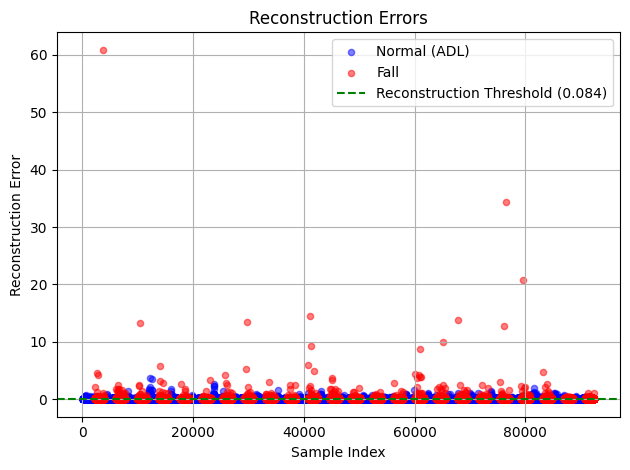

In [30]:
plt.scatter([i for i, l in zip(indices, test_labels) if l == 0], 
           [r for r, l in zip(test_recon_errors, test_labels) if l == 0],
           c='blue', label='Normal (ADL)', alpha=0.5, s=20)
plt.scatter([i for i, l in zip(indices, test_labels) if l == 1],
           [r for r, l in zip(test_recon_errors, test_labels) if l == 1],
           c='red', label='Fall', alpha=0.5, s=20)
plt.axhline(y=recon_threshold, color='green', linestyle='--', 
           label=f'Reconstruction Threshold ({recon_threshold:.3f})')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Errors')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

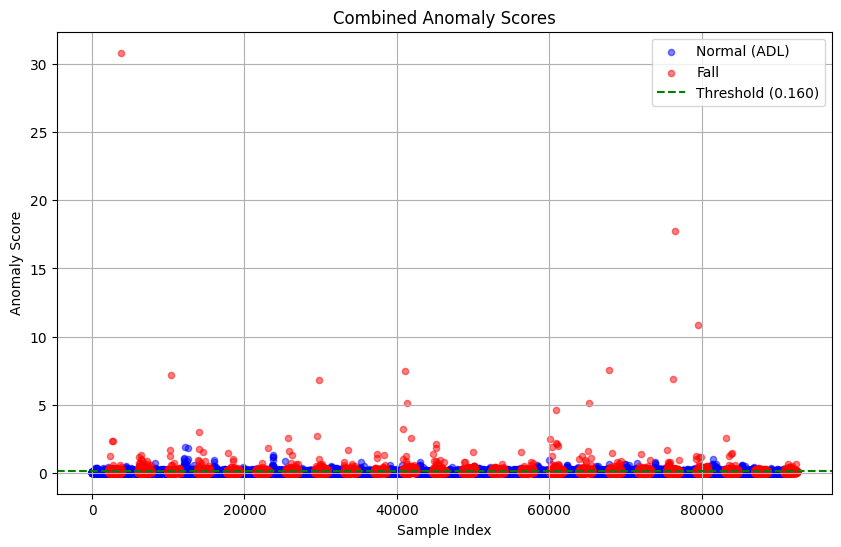

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter([i for i, l in zip(indices, test_labels) if l == 0], 
           [s for s, l in zip(anomaly_scores, test_labels) if l == 0],
           c='blue', label='Normal (ADL)', alpha=0.5, s=20)
plt.scatter([i for i, l in zip(indices, test_labels) if l == 1],
           [s for s, l in zip(anomaly_scores, test_labels) if l == 1],
           c='red', label='Fall', alpha=0.5, s=20)
plt.axhline(y=threshold, color='green', linestyle='--', 
           label=f'Threshold ({threshold:.3f})')
plt.xlabel('Sample Index')
plt.ylabel('Anomaly Score')
plt.title('Combined Anomaly Scores')
plt.legend()
plt.grid(True)
plt.show()